In [1]:
import os
import json
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from dataset import DPDataset
from model import return_2_fc, return_lstm, return_branch, CDPNet
from filehelp import make_file_name, show_series

# Move this to new dir
# Add augmentation

In [2]:
PATH = '/home/rocky/IMLEARN/Saved'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([128, 3])
tensor([-0.0000, -0.0240, -0.0553], dtype=torch.float64)
tensor([-0.0000, -0.0907, -0.2817], dtype=torch.float64)
tensor([-0.3379,  0.1421,  0.9776], dtype=torch.float64)
tensor([-0.0000, 0.2249, 1.2683], dtype=torch.float64)
tensor([-0.0000,  0.5633, -0.6382], dtype=torch.float64)


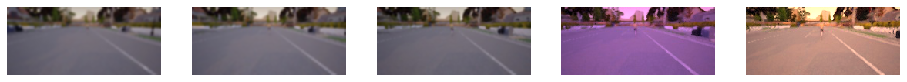

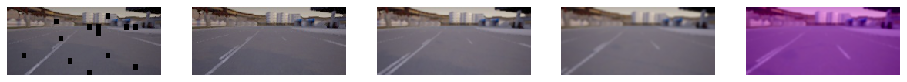

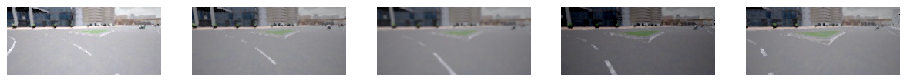

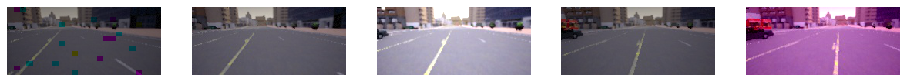

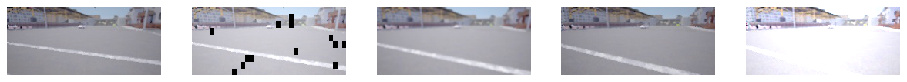

In [4]:
scales_dict =  {
    'car_vx':0.1,
    'dist_to_car':0.02,
    'dist_to_walker':0.02,
    'k':10,
    'headingerror':0.02,
    'cte':1
}

bs = 128

train_set = DPDataset(PATH, scales_dict=scales_dict,  seq_len=5, aug=True)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
iter_train = train_loader.__iter__()
X, y = next(iter_train)
print(y[1].shape)

#hist = plt.hist(y[1][:,0])

for i in range(5):
    print(y[1][i])
    show_series(X,i)

In [10]:
#dictionaries for parametrized network class
func_dict = {
    'cnn':torchvision.models.resnet18,
    'sensory':return_2_fc,
    'uncond':return_lstm,
    'main':return_lstm,
    'branch':return_branch
}

dims_dict = {
    'sensory_in':1,
    'sensory_hidden':64,
    'sensory_out':64,
    'cnn_out':128,
    'uncond_hidden':8,
    'uncond_nlayers':1,
    'uncond_out':3,
    'main_layers':1,
    'main_hidden':8,
    'branch_out':3,
    'branch_1':256,
    'branch_2':32
}
        
X, y = next(iter_train)     
X = [x.float() for x in X]
y = [x.float() for x in y]
model = CDPNet(func_dict, dims_dict)
with torch.no_grad():
    y_hat, hidden = model(X)

In [6]:
def mse_sum(pred, label):
    '''mse without averaging'''
    return (pred-label)**2

def mae_sum(pred, label):
    '''mae without averaging'''
    return abs(pred-label)

def branch_loss(pred, label, onehot_mask):
    '''
    onehot mask has a single ONE
    tiled in here for masking multidimensional branch output
    '''
    num_branches = 5
    num_out = 3
    
    label = label.repeat(1, num_branches).float()
    unmasked_losses = mse_sum(pred, label)
    tiled_mask = torch.repeat_interleave(X[2][:,-1,:], repeats=num_out, dim=1)
    
    masked_losses = unmasked_losses*tiled_mask
    masked_losses = masked_losses.sum(dim=1)
    return torch.mean(masked_losses)

def combined_loss(pred, label, mask, weights=(1, 1)):
    sensory_loss = F.mse_loss(pred[0], label[0])
    perception_loss = branch_loss(pred[1], label[1], mask)
    total_loss = sensory_loss*weights[0] + perception_loss*weights[1]
    return total_loss, sensory_loss, perception_loss

combined_loss(y_hat, y, X[2][:,-1,:])

(tensor(2.6635), tensor(0.5151), tensor(2.1484))

In [7]:
EPOCH = 5
BATCH_SIZE = 32
SEQ_LEN = 5
DEVICE = torch.device('cuda:0')
LR_INIT = 1e-4

train_set = DPDataset(PATH, seq_len=SEQ_LEN)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_set = DPDataset(PATH, seq_len=SEQ_LEN, val=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
iter_val = val_loader.__iter__()

model = CDPNet().to(DEVICE)
opt = torch.optim.RMSprop(model.parameters(), lr=LR_INIT)

hlc is bool in Saved/03_04_2020_19_36_Town03/targets/target_023962.json
e 0, b 0/1799, loss: 2.246, s_loss: 0.863, p_loss: 1.382, val loss: 2.2248618602752686
e 0, b 50/1799, loss: 2.818, s_loss: 0.247, p_loss: 2.571, val loss: 4.014413833618164
e 0, b 100/1799, loss: 2.270, s_loss: 0.220, p_loss: 2.050, val loss: 2.2245521545410156
e 0, b 150/1799, loss: 2.442, s_loss: 0.216, p_loss: 2.226, val loss: 2.4228806495666504
e 0, b 200/1799, loss: 2.173, s_loss: 0.217, p_loss: 1.955, val loss: 3.4369728565216064
e 0, b 250/1799, loss: 1.588, s_loss: 0.168, p_loss: 1.419, val loss: 2.9546806812286377
e 0, b 300/1799, loss: 2.167, s_loss: 0.144, p_loss: 2.024, val loss: 1.2988197803497314
e 0, b 350/1799, loss: 1.549, s_loss: 0.133, p_loss: 1.416, val loss: 3.17635178565979
hlc is bool in Saved/03_04_2020_19_36_Town03/targets/target_023994.json
e 0, b 400/1799, loss: 1.739, s_loss: 0.138, p_loss: 1.600, val loss: 2.633671283721924
e 0, b 450/1799, loss: 2.151, s_loss: 0.114, p_loss: 2.037, va

e 2, b 500/1799, loss: 0.491, s_loss: 0.033, p_loss: 0.458, val loss: 2.377140760421753
e 2, b 550/1799, loss: 0.482, s_loss: 0.039, p_loss: 0.443, val loss: 3.0062248706817627
e 2, b 600/1799, loss: 0.608, s_loss: 0.057, p_loss: 0.551, val loss: 2.400859832763672
e 2, b 650/1799, loss: 0.654, s_loss: 0.024, p_loss: 0.630, val loss: 2.1346724033355713
e 2, b 700/1799, loss: 0.398, s_loss: 0.047, p_loss: 0.351, val loss: 2.062929630279541
e 2, b 750/1799, loss: 0.711, s_loss: 0.019, p_loss: 0.691, val loss: 3.027932643890381
e 2, b 800/1799, loss: 0.396, s_loss: 0.023, p_loss: 0.373, val loss: 2.108041286468506
e 2, b 850/1799, loss: 0.867, s_loss: 0.050, p_loss: 0.817, val loss: 2.4744582176208496
e 2, b 900/1799, loss: 0.413, s_loss: 0.042, p_loss: 0.370, val loss: 4.107899188995361
e 2, b 950/1799, loss: 1.008, s_loss: 0.040, p_loss: 0.968, val loss: 3.9173290729522705
e 2, b 1000/1799, loss: 0.731, s_loss: 0.035, p_loss: 0.696, val loss: 2.495371103286743
e 2, b 1050/1799, loss: 0.9

e 4, b 1300/1799, loss: 0.929, s_loss: 0.023, p_loss: 0.906, val loss: 4.655776500701904
e 4, b 1350/1799, loss: 0.260, s_loss: 0.013, p_loss: 0.247, val loss: 0.34719040989875793
hlc is bool in Saved/03_04_2020_19_36_Town03/targets/target_023986.json
e 4, b 1400/1799, loss: 0.200, s_loss: 0.014, p_loss: 0.186, val loss: 4.686710834503174
e 4, b 1450/1799, loss: 0.133, s_loss: 0.026, p_loss: 0.107, val loss: 2.2761456966400146
e 4, b 1500/1799, loss: 0.187, s_loss: 0.018, p_loss: 0.168, val loss: 3.4566287994384766
e 4, b 1550/1799, loss: 0.491, s_loss: 0.016, p_loss: 0.474, val loss: 1.680851936340332
hlc is bool in Saved/03_04_2020_19_36_Town03/targets/target_023994.json
e 4, b 1600/1799, loss: 0.197, s_loss: 0.025, p_loss: 0.171, val loss: 2.425464630126953
e 4, b 1650/1799, loss: 0.414, s_loss: 0.025, p_loss: 0.388, val loss: 2.108832597732544
e 4, b 1700/1799, loss: 0.207, s_loss: 0.027, p_loss: 0.180, val loss: 2.7325375080108643
e 4, b 1750/1799, loss: 0.233, s_loss: 0.024, p_lo

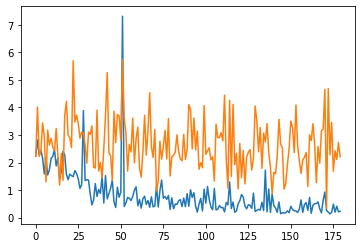

In [8]:
start = time.time()
train_loss_history = []
val_loss_history = []
val_freq = 50
save_freq = 100

total_batches = len(train_loader)
for e in range(EPOCH):
    for b, batch in enumerate(train_loader):
        X = batch[0]
        y = batch[1]
        X = [x.float().to(DEVICE) for x in X]
        y = [wy.float().to(DEVICE) for wy in y]
        
        pred, hidden_states = model(X)
        total_loss, s_loss, p_loss = combined_loss(pred, y, X[2][:,-1,:]) 
        
        total_loss.backward()
        opt.step()
        opt.zero_grad()
        
        if (b%val_freq==0):            
            model.eval()
            with torch.no_grad():
                X_val, y_val = next(iter_val)
                
            X_val = [x.float().to(DEVICE) for x in X_val]
            y_val = [wy.float().to(DEVICE) for wy in y_val]
            pred_val, hidden_states_val = model(X_val)
            loss_val = combined_loss(pred_val, y_val, X_val[2][:,-1,:])[0]
            
            val_loss_history.append(loss_val.item())
            train_loss_history.append(total_loss.item())
            
            print('e {}, b {}/{}, loss: {:.3f}, s_loss: {:.3f}, p_loss: {:.3f}, val loss: {:.3f}'.format(e, b, total_batches, total_loss, s_loss, p_loss, loss_val))
            
            model.train()
        
        
        #if b>=3:
            #break
            
plt.plot(train_loss_history)
plt.plot(val_loss_history)
print('Training took {} seconds'.format(time.time()-start))

In [9]:
test_set = DPDataset(PATH, seq_len=SEQ_LEN, val=True)
test_loader = DataLoader(test_set, batch_size=512)
iter_test = test_loader.__iter__()

for i in range(1):
    X, y = next(iter_test)
X = [x.float().to(DEVICE) for x in X]
y = [wy.float().to(DEVICE) for wy in y]

with torch.no_grad():
    pred, hidden_states = model(X)

RuntimeError: CUDA out of memory. Tried to allocate 2.69 GiB (GPU 0; 7.79 GiB total capacity; 4.50 GiB already allocated; 669.00 MiB free; 1.16 GiB cached)

In [ ]:
masked = pred[1]*torch.repeat_interleave(X[2][:,-1,:], repeats=3, dim=1)
masked = masked.view(-1, 5,3).sum(dim=1)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(masked[:,0].cpu().detach())
plt.plot(y[1][:,0].cpu())
plt.title('k')
plt.subplot(1,3,2)
plt.plot(masked[:,1].cpu().detach())
plt.plot(y[1][:,1].cpu())
plt.title('heading error')
plt.subplot(1,3,3)
plt.plot(masked[:,2].cpu().detach())
plt.plot(y[1][:,2].cpu())
plt.title('crosstrack error')
plt.suptitle('Conditional')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pred[0][:,0].cpu())
plt.plot(y[0][:,0].cpu())
plt.title('speed')
plt.subplot(1,3,2)
plt.plot(pred[0][:,1].cpu())
plt.plot(y[0][:,1].cpu())
plt.title('car dist')
plt.subplot(1,3,3)
plt.plot(pred[0][:,2].cpu())
plt.plot(y[0][:,2].cpu())
plt.title('pedestrian dist')
plt.suptitle('Unonditional')